## Evaluation Metrics for Cell Type Classification

In scRNAseq analysis, a common task is to predict cell type labels for unannotated (*query*) cells using a well-annotated *reference* dataset. But how do we know whether our method for achieving this goal is good? What metrics can we use to assess this?

In this notebook, we will:
1. Generate simple toy scRNAseq datasets with known cell type labels
2. Use k-nearest neighbors (kNN) to predict cell types in a query dataset
3. Define commonly used classifier metrics: sensitivity, precision, and accuracy.
4. Evaluate our predictions with these metrics
5. Extend our classification approach to more complex data having more than two classes and introduce pertinent metrics
6. Introduce parameter sweeps

### Environment setup

**Local (conda):** Create the environment from the provided [`classification_metrics_environment.yml`](classification_metrics_environment.yml):
```
conda env create -f classification_metrics_environment.yml
conda activate cscb
```

**Pip only:** Use [`classification_metrics_requirements.txt`](classification_metrics_requirements.txt):
```
pip install -r classification_metrics_requirements.txt
```

**Google Colab:** Run the cell below — it will detect Colab and install the required packages automatically.

In [92]:
import sys
if 'google.colab' in sys.modules:
    print("Colab detected — installing required packages...")
    !pip install -q numpy pandas matplotlib anndata scanpy scikit-learn
else:
    print("Local environment detected — skipping install.")

Local environment detected — skipping install.


In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Generating a toy reference dataset

To illustrate classification metrics, we'll create a simple simulated scRNAseq dataset with two cell types: **Neurons** and **Astrocytes**.

Our simulated data has 10 genes:
- **Neuron markers** (Snap25, Syt1, Rbfox3): highly expressed in neurons, low in astrocytes
- **Astrocyte markers** (Gfap, Aqp4, S100b): highly expressed in astrocytes, low in neurons
- **Housekeeping genes** (Actb, Gapdh, Rpl13a, Hsp90ab1): similar expression in both types

We generate expression counts from [negative binomial distributions](https://en.wikipedia.org/wiki/Negative_binomial_distribution), which are commonly used to model scRNAseq count data because they capture the **overdispersion** (extra variability beyond what a Poisson distribution would predict) that is characteristic of real sequencing measurements. Each gene has a mean expression level (μ) for each cell type, and a shared dispersion parameter (r) that controls how much extra variability there is — lower r means more noise.

In [24]:
np.random.seed(42)

gene_names = ['Snap25', 'Syt1', 'Rbfox3', 'Gfap', 'Aqp4', 'S100b',
              'Actb', 'Gapdh', 'Rpl13a', 'Hsp90ab1']

# Mean expression levels (mu) for each gene in each cell type
mean_expression = pd.DataFrame({
    'Neuron':    [4, 3, 3, 1, 1, 1, 2, 2, 2, 2],
    'Astrocyte': [1, 1, 1, 4, 3, 3, 2, 2, 2, 2]
}, index=gene_names)

# Dispersion parameter for negative binomial (lower = more noise)
dispersion = 2

print("Mean expression levels (mu):")
mean_expression

Mean expression levels (mu):


,Neuron,Astrocyte
Snap25,4,1
Syt1,3,1
Rbfox3,3,1
Gfap,1,4
Aqp4,1,3
S100b,1,3
Actb,2,2
Gapdh,2,2
Rpl13a,2,2
Hsp90ab1,2,2


In [25]:
def generate_cells(cell_type, n_cells, mean_expr_df, r=2):
    """Generate expression counts using the negative binomial distribution.
    
    Parameters
    ----------
    cell_type : str
        Column name in mean_expr_df
    n_cells : int
        Number of cells to generate
    mean_expr_df : pd.DataFrame
        Mean expression for each gene (rows) and cell type (columns)
    r : float
        Dispersion parameter. Lower = more overdispersion (noise).
        Variance = mu + mu^2/r
    """
    means = mean_expr_df[cell_type].values
    data = np.zeros((n_cells, len(means)), dtype=int)
    for j, mu in enumerate(means):
        if mu > 0:
            p = r / (r + mu)
            data[:, j] = np.random.negative_binomial(n=r, p=p, size=n_cells)
    return data

# Generate reference data: 100 cells of each type
n_ref = 100
ref_neurons = generate_cells('Neuron', n_ref, mean_expression, r=dispersion)
ref_astrocytes = generate_cells('Astrocyte', n_ref, mean_expression, r=dispersion)

# Combine into an AnnData object with ground truth labels
ad_ref = ad.AnnData(
    X=np.vstack([ref_neurons, ref_astrocytes]).astype(np.float32),
    obs=pd.DataFrame({'celltype': ['Neuron'] * n_ref + ['Astrocyte'] * n_ref}),
    var=pd.DataFrame(index=gene_names)
)

print(f"Reference dataset: {ad_ref.n_obs} cells x {ad_ref.n_vars} genes")
ad_ref.obs['celltype'].value_counts()

Reference dataset: 200 cells x 10 genes


/opt/homebrew/Caskroom/miniforge/base/envs/autocluster/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


celltype
Neuron       100
Astrocyte    100
Name: count, dtype: int64

### Visualizing the reference data

Let's plot the expression of a neuron marker gene (Snap25) against an astrocyte marker gene (Gfap) to see how well the two cell types separate. Because expression is stochastic, some cells from different types may overlap in this 2D view.

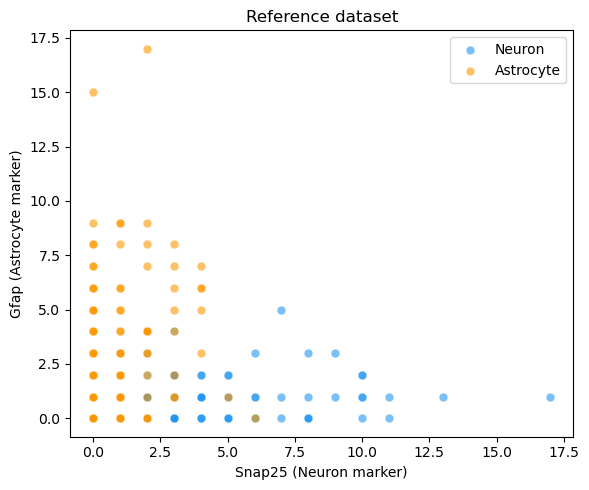

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))

colors = {'Neuron': '#2196F3', 'Astrocyte': '#FF9800'}
snap25_idx = gene_names.index('Snap25')
gfap_idx = gene_names.index('Gfap')

for ct, color in colors.items():
    mask = (ad_ref.obs['celltype'] == ct).values
    ax.scatter(
        ad_ref.X[mask, snap25_idx],
        ad_ref.X[mask, gfap_idx],
        label=ct, alpha=0.6, s=40, color=color,
        edgecolors='white', linewidth=0.5
    )

ax.set_xlabel('Snap25 (Neuron marker)')
ax.set_ylabel('Gfap (Astrocyte marker)')
ax.set_title('Reference dataset')
ax.legend()
plt.tight_layout()
plt.show()

### Generating a query dataset

Now we generate a **query** dataset from the *same distribution* as the reference — simulating a new experiment that measured the same cell types.

In a real scenario, the query cells would **not** have labels. Here, we generate them with known labels so we can later evaluate our classifier, but we store the true labels *separately* and do not include them in the AnnData object — simulating the real situation where labels are unknown.

In [28]:
# Generate query data: 50 cells of each type
n_query = 50
query_neurons = generate_cells('Neuron', n_query, mean_expression, r=dispersion)
query_astrocytes = generate_cells('Astrocyte', n_query, mean_expression, r=dispersion)

query_data = np.vstack([query_neurons, query_astrocytes])
query_true_labels = np.array(['Neuron'] * n_query + ['Astrocyte'] * n_query)

# Shuffle so cells are not grouped by type (more realistic)
shuffle_idx = np.random.permutation(len(query_true_labels))
query_data = query_data[shuffle_idx]
query_true_labels = query_true_labels[shuffle_idx]

# Create AnnData WITHOUT cell type labels
ad_query = ad.AnnData(
    X=query_data.astype(np.float32),
    var=pd.DataFrame(index=gene_names)
)

print(f"Query dataset: {ad_query.n_obs} cells x {ad_query.n_vars} genes")
print("Obs columns:", list(ad_query.obs.columns))
print("Note: no cell type labels — these are 'unknown' and we want to predict them.")

Query dataset: 100 cells x 10 genes
Obs columns: []
Note: no cell type labels — these are 'unknown' and we want to predict them.


### Predicting cell types with k-nearest neighbors (kNN)

The idea behind kNN classification is straightforward:

1. For each query cell, find the **k** most similar cells in the reference data (its *nearest neighbors*) based on gene expression distance
2. Look at the cell type labels of those k neighbors
3. Assign the query cell the most common label among its neighbors (majority vote)

We'll use `k=5` and Euclidean distance on the raw expression counts.

> **Note:** In practice with real scRNAseq data, you would typically normalize expression values and reduce dimensionality (e.g., with PCA) before computing distances. We skip these steps here since our toy data has only 10 genes and cells have comparable total counts.

In [29]:
# Prepare training and query data
X_train = ad_ref.X
y_train = ad_ref.obs['celltype'].values
X_query = ad_query.X

# Train kNN classifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Predict cell types for query cells
predictions = knn.predict(X_query)
ad_query.obs['predicted_celltype'] = predictions

print(f"Predicted cell type counts:")
print(ad_query.obs['predicted_celltype'].value_counts())

Predicted cell type counts:
predicted_celltype
Astrocyte    51
Neuron       49
Name: count, dtype: int64


### How did we do?

Now let's reveal the true labels and compare them to our predictions. Remember, in this toy example we have the luxury of knowing the ground truth because we generated the data. In a real experiment, you would need a separate validation dataset with known labels to evaluate your classifier.

In [30]:
# Add ground truth to the query AnnData
ad_query.obs['true_celltype'] = query_true_labels

# Side-by-side comparison
comparison = ad_query.obs[['true_celltype', 'predicted_celltype']].copy()
comparison['correct'] = comparison['true_celltype'] == comparison['predicted_celltype']

print(comparison.to_string())
print(f"\n{comparison['correct'].sum()} out of {len(comparison)} predictions correct")

   true_celltype predicted_celltype  correct
0         Neuron             Neuron     True
1         Neuron             Neuron     True
2      Astrocyte          Astrocyte     True
3         Neuron             Neuron     True
4         Neuron             Neuron     True
5      Astrocyte          Astrocyte     True
6         Neuron             Neuron     True
7      Astrocyte          Astrocyte     True
8         Neuron             Neuron     True
9      Astrocyte          Astrocyte     True
10        Neuron             Neuron     True
11     Astrocyte             Neuron    False
12        Neuron             Neuron     True
13        Neuron          Astrocyte    False
14        Neuron             Neuron     True
15        Neuron             Neuron     True
16     Astrocyte          Astrocyte     True
17        Neuron          Astrocyte    False
18        Neuron             Neuron     True
19     Astrocyte          Astrocyte     True
20        Neuron             Neuron     True
21     Ast

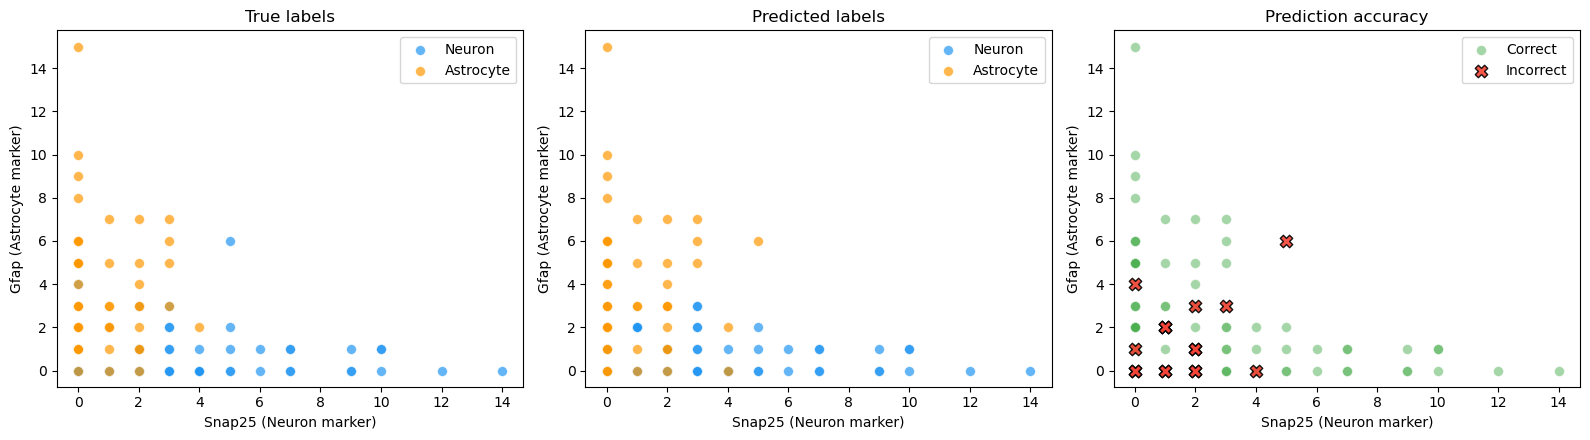

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

colors = {'Neuron': '#2196F3', 'Astrocyte': '#FF9800'}
snap25_idx = gene_names.index('Snap25')
gfap_idx = gene_names.index('Gfap')

# Panel 1: True labels
for ct, color in colors.items():
    mask = (ad_query.obs['true_celltype'] == ct).values
    axes[0].scatter(ad_query.X[mask, snap25_idx], ad_query.X[mask, gfap_idx],
                    label=ct, alpha=0.7, s=50, color=color,
                    edgecolors='white', linewidth=0.5)
axes[0].set_title('True labels')

# Panel 2: Predicted labels
for ct, color in colors.items():
    mask = (ad_query.obs['predicted_celltype'] == ct).values
    axes[1].scatter(ad_query.X[mask, snap25_idx], ad_query.X[mask, gfap_idx],
                    label=ct, alpha=0.7, s=50, color=color,
                    edgecolors='white', linewidth=0.5)
axes[1].set_title('Predicted labels')

# Panel 3: Correct vs incorrect
correct = (ad_query.obs['true_celltype'] == ad_query.obs['predicted_celltype']).values
axes[2].scatter(ad_query.X[correct, snap25_idx], ad_query.X[correct, gfap_idx],
                label='Correct', alpha=0.5, s=50, color='#4CAF50',
                edgecolors='white', linewidth=0.5)
axes[2].scatter(ad_query.X[~correct, snap25_idx], ad_query.X[~correct, gfap_idx],
                label='Incorrect', alpha=0.9, s=80, color='#F44336',
                edgecolors='black', linewidth=1, marker='X')
axes[2].set_title('Prediction accuracy')

for ax in axes:
    ax.set_xlabel('Snap25 (Neuron marker)')
    ax.set_ylabel('Gfap (Astrocyte marker)')
    ax.legend()

plt.tight_layout()
plt.show()

### Evaluating predictions: the confusion matrix

To systematically evaluate a binary classifier, we first designate one class as **positive** and the other as **negative**. This choice is application-dependent. Here, let's define:

- **Positive class** = Neuron
- **Negative class** = Astrocyte

Every prediction then falls into one of four categories:

|  | Predicted Neuron (+) | Predicted Astrocyte (−) |
|---|---|---|
| **Actual Neuron (+)** | True Positive (TP) | False Negative (FN) |
| **Actual Astrocyte (−)** | False Positive (FP) | True Negative (TN) |

- **TP (True Positive):** The cell *is* a Neuron and we correctly predicted Neuron
- **FP (False Positive):** The cell *is* an Astrocyte but we incorrectly predicted Neuron
- **TN (True Negative):** The cell *is* an Astrocyte and we correctly predicted Astrocyte
- **FN (False Negative):** The cell *is* a Neuron but we incorrectly predicted Astrocyte

These four numbers are organized into a **confusion matrix**.

In [32]:
# Compute confusion matrix
# Rows = actual label, Columns = predicted label
# With labels=['Neuron', 'Astrocyte']:
#   Row 0 = actual Neuron,    Row 1 = actual Astrocyte
#   Col 0 = predicted Neuron, Col 1 = predicted Astrocyte

cm = confusion_matrix(
    ad_query.obs['true_celltype'],
    ad_query.obs['predicted_celltype'],
    labels=['Neuron', 'Astrocyte']
)

TP = cm[0, 0]  # Actual Neuron,    Predicted Neuron
FN = cm[0, 1]  # Actual Neuron,    Predicted Astrocyte
FP = cm[1, 0]  # Actual Astrocyte, Predicted Neuron
TN = cm[1, 1]  # Actual Astrocyte, Predicted Astrocyte

print(f"True Positives  (TP): {TP}  — Neurons correctly identified")
print(f"False Positives (FP): {FP}  — Astrocytes incorrectly called Neurons")
print(f"True Negatives  (TN): {TN}  — Astrocytes correctly identified")
print(f"False Negatives (FN): {FN}  — Neurons incorrectly called Astrocytes")

True Positives  (TP): 41  — Neurons correctly identified
False Positives (FP): 8  — Astrocytes incorrectly called Neurons
True Negatives  (TN): 42  — Astrocytes correctly identified
False Negatives (FN): 9  — Neurons incorrectly called Astrocytes


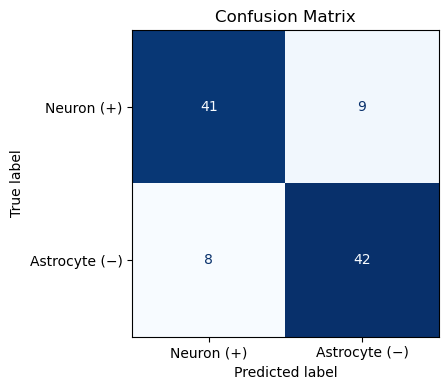

In [33]:
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Neuron (+)', 'Astrocyte (−)']
)
disp.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Sensitivity (Recall, True Positive Rate)

**Sensitivity** answers the question: *Of all actual Neurons in the query data, what fraction did we correctly identify?*

$\text{Sensitivity} = \frac{TP}{TP + FN}$

- A sensitivity of 1.0 means we found **every** Neuron.
- Low sensitivity means we are *missing* many Neurons — they're being mislabeled as Astrocytes.

In a cell typing context, low sensitivity for a cell type means your classifier is **failing to detect** cells of that type — they are being erroneously assigned a different label.

In [34]:
sensitivity = TP / (TP + FN)
print(f"Sensitivity = TP / (TP + FN) = {TP} / ({TP} + {FN}) = {sensitivity:.3f}")
print(f"\nInterpretation: {sensitivity:.1%} of actual Neurons were correctly identified.")

Sensitivity = TP / (TP + FN) = 41 / (41 + 9) = 0.820

Interpretation: 82.0% of actual Neurons were correctly identified.


### Precision (Positive Predictive Value)

**Precision** answers a different question: *Of all cells we predicted as Neurons, what fraction actually are Neurons?*

$$\text{Precision} = \frac{TP}{TP + FP}$$

- A precision of 1.0 means every cell we called a Neuron really is one.
- Low precision means many of our "Neuron" predictions are actually Astrocytes — our Neuron calls are *contaminated*.

In cell typing, low precision for a cell type means your predicted population is **impure** — it contains cells that don't truly belong to that type.

In [35]:
precision = TP / (TP + FP)
print(f"Precision = TP / (TP + FP) = {TP} / ({TP} + {FP}) = {precision:.3f}")
print(f"\nInterpretation: {precision:.1%} of cells predicted as Neurons are actually Neurons.")

Precision = TP / (TP + FP) = 41 / (41 + 8) = 0.837

Interpretation: 83.7% of cells predicted as Neurons are actually Neurons.


### Accuracy

**Accuracy** is the most intuitive metric: *What fraction of all predictions are correct?*

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Accuracy treats all correct predictions equally. While easy to understand, it can be **misleading when classes are imbalanced**. For example, if 95% of your cells are Neurons, a classifier that *always* predicts "Neuron" would achieve 95% accuracy despite never identifying a single Astrocyte. This is why sensitivity and precision are important complements to accuracy.

In [36]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy = (TP + TN) / (TP + TN + FP + FN)")
print(f"         = ({TP} + {TN}) / ({TP} + {TN} + {FP} + {FN})")
print(f"         = {accuracy:.3f}")
print(f"\nInterpretation: {accuracy:.1%} of all query cells were classified correctly.")

Accuracy = (TP + TN) / (TP + TN + FP + FN)
         = (41 + 42) / (41 + 42 + 8 + 9)
         = 0.830

Interpretation: 83.0% of all query cells were classified correctly.


We can verify our manual calculations using `scikit-learn`:

In [37]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

print("Verification with sklearn:")
print(f"  Sensitivity (recall): {recall_score(query_true_labels, predictions, pos_label='Neuron'):.3f}")
print(f"  Precision:            {precision_score(query_true_labels, predictions, pos_label='Neuron'):.3f}")
print(f"  Accuracy:             {accuracy_score(query_true_labels, predictions):.3f}")

Verification with sklearn:
  Sensitivity (recall): 0.820
  Precision:            0.837
  Accuracy:             0.830


### Summary

| Metric | Formula | Question it answers |
|---|---|---|
| **Sensitivity** (Recall) | TP / (TP + FN) | Of all actual positives, how many did we detect? |
| **Precision** (PPV) | TP / (TP + FP) | Of all predicted positives, how many are correct? |
| **Accuracy** | (TP + TN) / Total | Overall, what fraction of predictions are correct? |

**Key takeaways:**

- Sensitivity and precision answer *different questions* about your classifier. You need both to fully understand its performance.
- Accuracy is intuitive but can be misleading with imbalanced class proportions.
- The choice of which class is "positive" affects sensitivity and precision values (but not accuracy).
- These metrics are the building blocks for more advanced evaluation measures such as the F1 score, specificity, AUROC, and multi-class extensions, which we will explore next.

---
## Part 2: Multi-class evaluation and the F1 score

In Part 1 we evaluated a binary classifier (two cell types). In practice, scRNAseq datasets contain many cell types, and we need metrics that handle **multi-class** classification.

In this section we will:
1. Generate a toy dataset with **three** cell types — including two that are harder to tell apart
2. Normalize the data and visualize it with PCA
3. Classify with kNN and examine the per-class confusion matrix
4. Introduce the **F1 score** and its multi-class variants: **macro**, **micro**, and **weighted**

### Generating a three-class dataset

We now simulate three cell types: **Neurons**, **Astrocytes**, and **Oligodendrocytes**. Astrocytes and Oligodendrocytes are both glial cell types that share some gene expression characteristics, making them harder to distinguish from each other than from Neurons.

We also make the class sizes **imbalanced** — Oligodendrocytes are the rarest population. This is common in real scRNAseq data, where some cell types are much less abundant than others.

We expand the gene panel to 12 genes — 3 markers per cell type plus 3 housekeeping genes.

In [38]:
np.random.seed(123)

gene_names_3 = ['Snap25', 'Syt1', 'Rbfox3',      # Neuron markers
                'Gfap', 'Aqp4', 'S100b',          # Astrocyte markers
                'Mbp', 'Plp1', 'Mog',             # Oligodendrocyte markers
                'Actb', 'Gapdh', 'Rpl13a']        # Housekeeping

mean_expression_3 = pd.DataFrame({
    #                   Snap25 Syt1 Rbfox3 Gfap Aqp4 S100b Mbp  Plp1 Mog  Actb Gapdh Rpl13a
    'Neuron':          [5,     4,   4,     1,   1,   1,    1,   1,   1,   2,   2,    2],
    'Astrocyte':       [1,     1,   1,     4,   3,   3,    2,   1.5, 1,   2,   2,    2],
    'Oligodendrocyte': [1,     1,   1,     2,   1.5, 1,    4,   3,   3,   2,   2,    2]
}, index=gene_names_3)

print("Mean expression levels (mu) — note the overlap between Astrocyte and Oligodendrocyte:")
mean_expression_3

Mean expression levels (mu) — note the overlap between Astrocyte and Oligodendrocyte:


,Neuron,Astrocyte,Oligodendrocyte
Snap25,5,1.0,1.0
Syt1,4,1.0,1.0
Rbfox3,4,1.0,1.0
Gfap,1,4.0,2.0
Aqp4,1,3.0,1.5
S100b,1,3.0,1.0
Mbp,1,2.0,4.0
Plp1,1,1.5,3.0
Mog,1,1.0,3.0
Actb,2,2.0,2.0


In [39]:
# Imbalanced class sizes — Oligodendrocytes are rare
ref_sizes = {'Neuron': 150, 'Astrocyte': 100, 'Oligodendrocyte': 50}
query_sizes = {'Neuron': 60, 'Astrocyte': 40, 'Oligodendrocyte': 20}

# Generate reference data
ref_arrays, ref_labels = [], []
for ct, n in ref_sizes.items():
    ref_arrays.append(generate_cells(ct, n, mean_expression_3, r=dispersion))
    ref_labels.extend([ct] * n)

ad_ref3 = ad.AnnData(
    X=np.vstack(ref_arrays).astype(np.float32),
    obs=pd.DataFrame({'celltype': ref_labels}),
    var=pd.DataFrame(index=gene_names_3)
)

# Generate query data
query_arrays, query_labels_3 = [], []
for ct, n in query_sizes.items():
    query_arrays.append(generate_cells(ct, n, mean_expression_3, r=dispersion))
    query_labels_3.extend([ct] * n)

query_data_3 = np.vstack(query_arrays).astype(np.float32)
query_true_labels_3 = np.array(query_labels_3)

# Shuffle query cells
shuf = np.random.permutation(len(query_true_labels_3))
query_data_3 = query_data_3[shuf]
query_true_labels_3 = query_true_labels_3[shuf]

ad_query3 = ad.AnnData(
    X=query_data_3,
    var=pd.DataFrame(index=gene_names_3)
)

print(f"Reference: {ad_ref3.n_obs} cells, Query: {ad_query3.n_obs} cells, Genes: {ad_ref3.n_vars}")
print("\nReference class sizes:")
print(ad_ref3.obs['celltype'].value_counts())
print(f"\nQuery class sizes (hidden ground truth):")
print(pd.Series(query_true_labels_3).value_counts())

Reference: 300 cells, Query: 120 cells, Genes: 12

Reference class sizes:
celltype
Neuron             150
Astrocyte          100
Oligodendrocyte     50
Name: count, dtype: int64

Query class sizes (hidden ground truth):
Neuron             60
Astrocyte          40
Oligodendrocyte    20
Name: count, dtype: int64


/opt/homebrew/Caskroom/miniforge/base/envs/autocluster/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Normalization and PCA

With more genes and cell types, we now follow a more standard scRNAseq preprocessing workflow:

1. **Combine** the reference and query into a single AnnData object
2. **Library-size normalization** — scale each cell so total counts are comparable (`sc.pp.normalize_total`)
3. **Log transformation** — stabilize variance and compress the range (`sc.pp.log1p`)
4. **PCA** — reduce dimensionality to the top principal components (`sc.tl.pca`)

We concatenate reference and query cells and run PCA on the combined object so that both datasets share the same coordinate system. We tag each cell with a `dataset` label so we can distinguish them later.

/opt/homebrew/Caskroom/miniforge/base/envs/autocluster/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


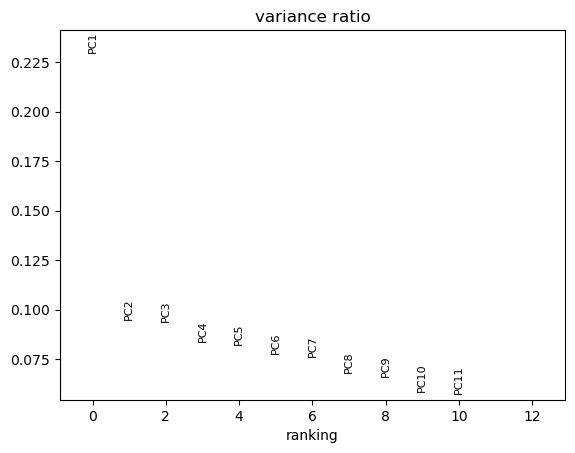

In [40]:
# Tag each dataset before combining
ad_ref3.obs['dataset'] = 'reference'
ad_query3.obs['dataset'] = 'query'
ad_query3.obs['celltype'] = 'Unknown'

# Concatenate reference and query
ad_combined = ad.concat([ad_ref3, ad_query3])
ad_combined.obs_names_make_unique()

# Store raw counts, then normalize
ad_combined.layers['counts'] = ad_combined.X.copy()
sc.pp.normalize_total(ad_combined)
sc.pp.log1p(ad_combined)

# Run PCA on the combined data
sc.tl.pca(ad_combined)

# Scree plot — variance explained by each PC
sc.pl.pca_variance_ratio(ad_combined, n_pcs=12)

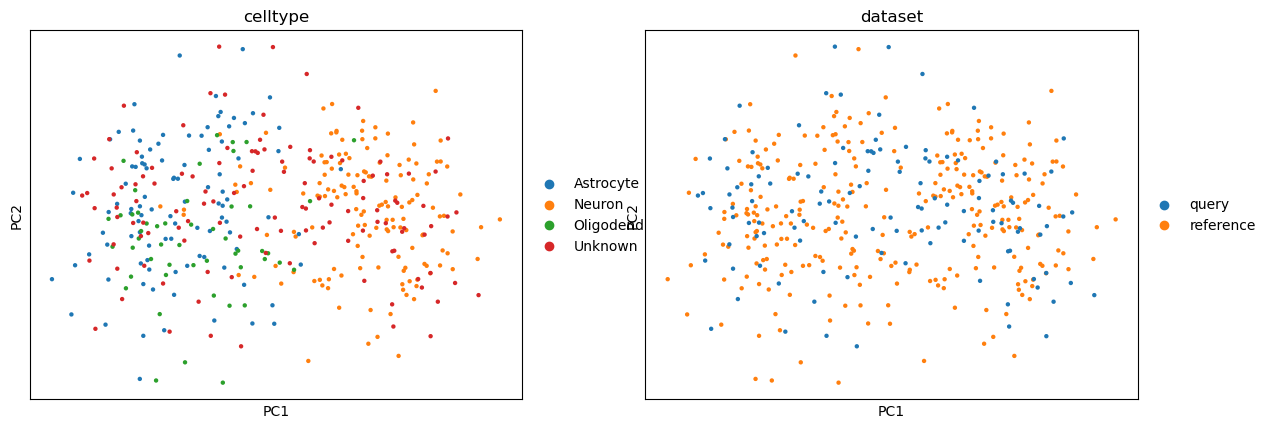

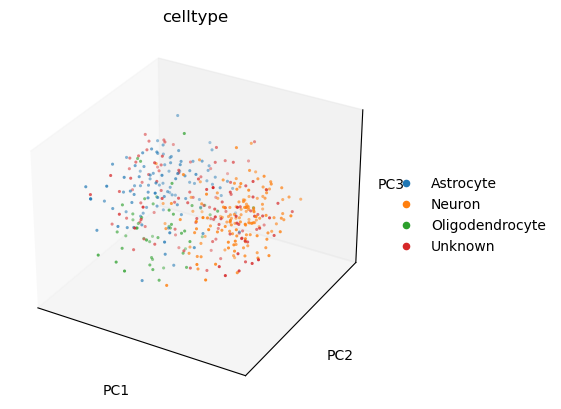

In [41]:
# 2D PCA embedding colored by cell type and dataset
sc.pl.pca(ad_combined, color=['celltype', 'dataset'], size=40)

# 3D PCA embedding of the first 3 PCs
sc.pl.pca(ad_combined, color='celltype', projection='3d')

Notice that **Neurons** form a well-separated cluster, while **Astrocytes** and **Oligodendrocytes** overlap more in the combined PCA embedding. This overlap — caused by shared glial marker expression — will lead to more classification errors between these two cell types. The 3D view reveals additional separation along PC3 that is not visible in the 2D projection.

### kNN classification on PCA coordinates

We extract the PCA coordinates for reference and query cells from the combined object, then train kNN on the reference cells and predict query cell types.

In [19]:
# Extract PCA coordinates for reference and query cells
ref_mask = ad_combined.obs['dataset'] == 'reference'
query_mask = ad_combined.obs['dataset'] == 'query'
X_ref_pca = ad_combined.obsm['X_pca'][ref_mask.values]
X_query_pca = ad_combined.obsm['X_pca'][query_mask.values]

# Train kNN on reference, predict query
knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(X_ref_pca, ad_combined.obs.loc[ref_mask, 'celltype'].values)
predictions_3 = knn3.predict(X_query_pca)

n_correct = (predictions_3 == query_true_labels_3).sum()
print(f"{n_correct} out of {len(predictions_3)} predictions correct ({n_correct/len(predictions_3):.1%})")
print(f"\nPredicted counts:\n{pd.Series(predictions_3).value_counts()}")
print(f"\nTrue counts:\n{pd.Series(query_true_labels_3).value_counts()}")

96 out of 120 predictions correct (80.0%)

Predicted counts:
Neuron             61
Astrocyte          48
Oligodendrocyte    11
Name: count, dtype: int64

True counts:
Neuron             60
Astrocyte          40
Oligodendrocyte    20
Name: count, dtype: int64


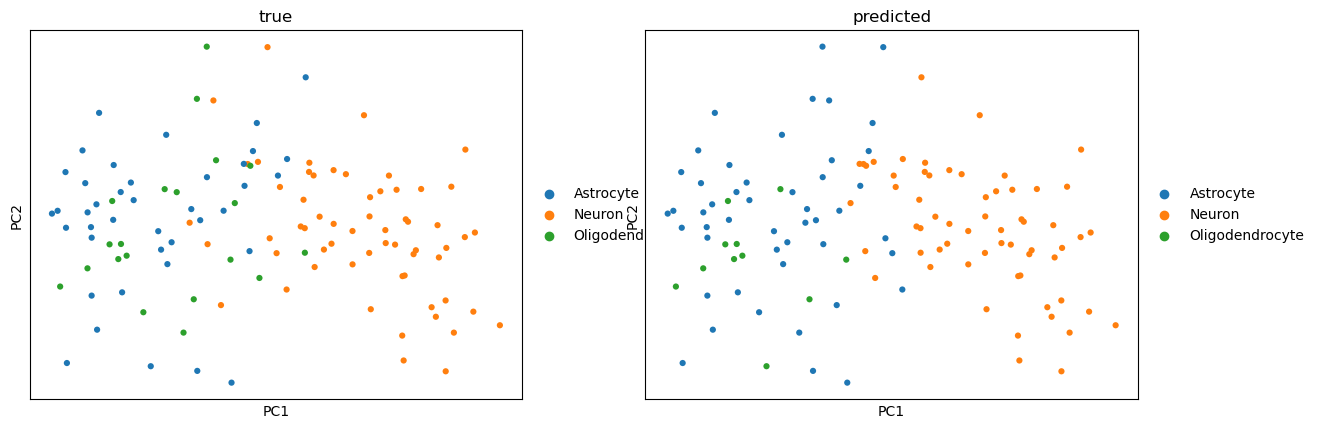

In [42]:
# Store predictions and true labels in the combined object
ad_combined.obs.loc[query_mask, 'predicted'] = predictions_3
ad_combined.obs.loc[query_mask, 'true'] = query_true_labels_3

# Also keep standalone references for downstream cells
ad_query3.obs['predicted'] = predictions_3
ad_query3.obs['true'] = query_true_labels_3

# Visualize query cells: true vs predicted labels in PCA space
ad_query_pca = ad_combined[query_mask].copy()
sc.pl.pca(ad_query_pca, color=['true', 'predicted'], size=80)

### Multi-class confusion matrix

With three classes, the confusion matrix is 3×3. Each row corresponds to the true class and each column to the predicted class. The diagonal entries are correct predictions; off-diagonal entries show which classes are confused with each other.

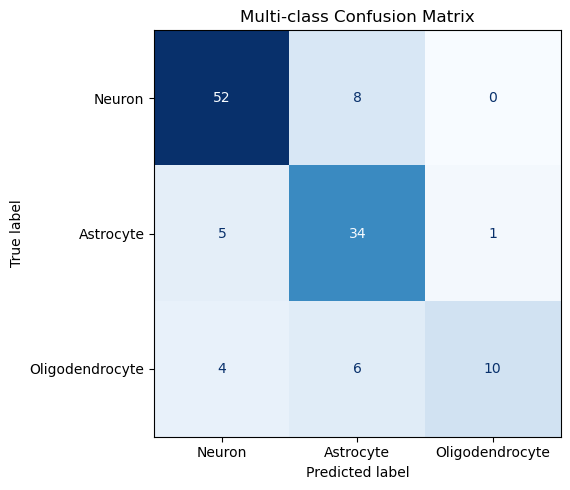

In [43]:
class_order = ['Neuron', 'Astrocyte', 'Oligodendrocyte']
cm3 = confusion_matrix(query_true_labels_3, predictions_3, labels=class_order)

fig, ax = plt.subplots(figsize=(6, 5))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=class_order)
disp3.plot(cmap='Blues', ax=ax, colorbar=False)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Multi-class Confusion Matrix')
plt.tight_layout()
plt.show()

### The F1 score

In Part 1 we saw that precision and sensitivity (recall) capture different aspects of classifier performance. Sometimes we want a **single number** that balances both. The **F1 score** is the [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall:

$$F_1 = 2 \cdot \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

The F1 score ranges from 0 (worst) to 1 (perfect). It is high only when *both* precision and recall are high. If either is low, F1 is pulled down.

#### Per-class F1

In a multi-class setting, we compute precision, recall, and F1 **for each class separately** using a one-vs-rest approach. For class *c*:
- **TP** = cells that are truly *c* and predicted *c*
- **FP** = cells that are *not* *c* but predicted *c*
- **FN** = cells that are truly *c* but predicted as something else

`sklearn.metrics.classification_report` computes all of this for us:

In [44]:
from sklearn.metrics import classification_report

print(classification_report(query_true_labels_3, predictions_3, 
                            labels=class_order, target_names=class_order, digits=3))

                 precision    recall  f1-score   support

         Neuron      0.852     0.867     0.860        60
      Astrocyte      0.708     0.850     0.773        40
Oligodendrocyte      0.909     0.500     0.645        20

       accuracy                          0.800       120
      macro avg      0.823     0.739     0.759       120
   weighted avg      0.814     0.800     0.795       120



Look at how the per-class F1 scores differ:

- **Neurons** have a high F1 — they are well-separated in gene expression space and easy to classify.
- **Astrocytes** and **Oligodendrocytes** have lower F1 — they share glial markers and are frequently confused with each other.
- **Oligodendrocytes** may have the lowest F1 — they are both rare (fewer training examples) and similar to Astrocytes.

### Summarizing multi-class performance: macro, micro, and weighted F1

With per-class F1 scores in hand, how do we summarize overall performance in a single number? There are three common approaches:

#### Macro F1
Take the **unweighted average** of per-class F1 scores:

$$F_{1,\text{macro}} = \frac{1}{C} \sum_{c=1}^{C} F_{1,c}$$

Macro F1 treats **every class equally**, regardless of how many cells belong to it. A rare cell type with poor F1 pulls the macro average down just as much as a common one. Use macro F1 when you care about performance on *every* cell type, including rare ones.

#### Micro F1
Pool all TP, FP, and FN across classes and compute a single F1:

$$F_{1,\text{micro}} = 2 \cdot \frac{\sum TP_c}{2 \cdot \sum TP_c + \sum FP_c + \sum FN_c}$$

For single-label multi-class classification (each cell has exactly one label), **micro F1 equals accuracy**. It is dominated by the most common classes.

#### Weighted F1
Average per-class F1 scores, **weighted by the number of true instances** of each class:

$$F_{1,\text{weighted}} = \sum_{c=1}^{C} \frac{n_c}{N} \cdot F_{1,c}$$

Weighted F1 accounts for class imbalance: common cell types contribute more to the overall score. It sits between micro and macro F1.

#### When to use which?

| Metric | Best for | Sensitive to rare classes? |
|---|---|---|
| **Macro F1** | Ensuring all cell types are well-classified | Yes — treats all classes equally |
| **Micro F1** | Overall correctness (= accuracy) | No — dominated by common classes |
| **Weighted F1** | Balanced summary accounting for prevalence | Somewhat — proportional to class size |

In [115]:
from sklearn.metrics import f1_score

f1_macro    = f1_score(query_true_labels_3, predictions_3, average='macro')
f1_micro    = f1_score(query_true_labels_3, predictions_3, average='micro')
f1_weighted = f1_score(query_true_labels_3, predictions_3, average='weighted')

print(f"F1 macro:    {f1_macro:.3f}  (unweighted average across classes)")
print(f"F1 micro:    {f1_micro:.3f}  (= accuracy for single-label classification)")
print(f"F1 weighted: {f1_weighted:.3f}  (weighted by class size)")

F1 macro:    0.759  (unweighted average across classes)
F1 micro:    0.800  (= accuracy for single-label classification)
F1 weighted: 0.795  (weighted by class size)


Notice the pattern:

- **Micro F1** (accuracy) is the highest — it is dominated by the well-classified Neurons, which make up the largest class.
- **Weighted F1** is slightly lower — it downweights the rarer Oligodendrocytes but still reflects their poor performance somewhat.
- **Macro F1** is the lowest — it gives equal weight to each class, so the poor Oligodendrocyte F1 drags the average down.

This is a concrete example of why accuracy alone can be misleading with imbalanced data. If we only looked at accuracy (micro F1), we might think the classifier is doing well overall, while macro F1 reveals that rare cell types are being poorly classified.

### Summary

| Metric | Scope | Key idea |
|---|---|---|
| **Per-class F1** | One class at a time | Harmonic mean of that class's precision and recall |
| **Macro F1** | All classes, equal weight | Are *all* cell types well-classified? |
| **Micro F1** | All classes, pooled | What fraction of cells are correct? (= accuracy) |
| **Weighted F1** | All classes, size-weighted | Overall quality, accounting for prevalence |

**Key takeaways:**

- The F1 score balances precision and recall into a single number.
- In multi-class problems, look at **per-class F1** to identify which cell types your classifier struggles with.
- Choose the right averaging method for your question: **macro** if rare cell types matter equally, **weighted** for a prevalence-aware summary, **micro** for raw accuracy.

### Exploring the effect of k and number of PCs

The performance of a kNN classifier depends on two key hyperparameters:

- **k** — the number of neighbors used for the majority vote
- **Number of PCs** — how many principal components we use as features

Too few PCs may discard informative variation, while too many may introduce noise. Similarly, k=1 can be noisy (sensitive to individual outlier cells), while very large k may blur the boundaries between similar cell types.

Let's systematically vary both parameters and measure how classification performance changes.

In [45]:
from sklearn.metrics import accuracy_score

n_pcs_range = [1, 2, 3, 5, 7, 10]
k_range = [1, 3, 5, 10, 15, 20]

results = []
for n_pcs in n_pcs_range:
    for k_val in k_range:
        X_ref_k = ad_combined.obsm['X_pca'][ref_mask.values, :n_pcs]
        X_query_k = ad_combined.obsm['X_pca'][query_mask.values, :n_pcs]
        
        knn_sweep = KNeighborsClassifier(n_neighbors=k_val)
        knn_sweep.fit(X_ref_k, ad_combined.obs.loc[ref_mask, 'celltype'].values)
        preds = knn_sweep.predict(X_query_k)
        
        results.append({
            'n_pcs': n_pcs,
            'k': k_val,
            'Accuracy': accuracy_score(query_true_labels_3, preds),
            'Weighted F1': f1_score(query_true_labels_3, preds, average='weighted'),
            'Macro F1': f1_score(query_true_labels_3, preds, average='macro')
        })

results_df = pd.DataFrame(results)
print(f"Tested {len(results_df)} parameter combinations")
results_df.head(10)

NameError: name 'f1_score' is not defined

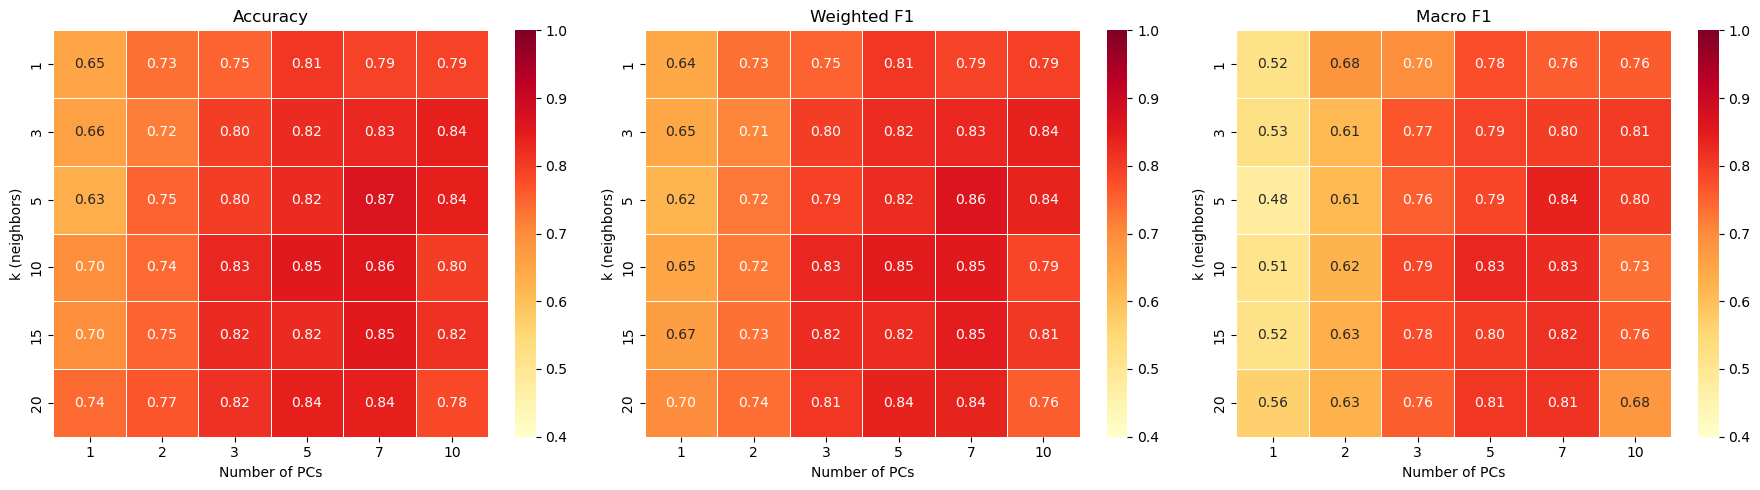

In [117]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric in zip(axes, ['Accuracy', 'Weighted F1', 'Macro F1']):
    pivot = results_df.pivot(index='k', columns='n_pcs', values=metric)
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
                vmin=0.4, vmax=1.0, linewidths=0.5)
    ax.set_title(metric)
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('k (neighbors)')

plt.tight_layout()
plt.show()

**Observations:**

- **Very few PCs (1–2) hurt performance** — there isn't enough information to distinguish all three cell types, particularly Astrocytes from Oligodendrocytes.
- **Performance generally improves with more PCs** up to a point, as additional components capture meaningful biological variation.
- **k=1 tends to be noisy** — a single nearest neighbor can easily be an outlier, leading to misclassifications.
- **Moderate k values (3–10) often perform best**, balancing robustness against over-smoothing.
- **Very large k can degrade performance** for rare cell types like Oligodendrocytes, because the majority vote is dominated by the more abundant classes.
- **Macro F1 is most sensitive** to these parameter choices because it weights all cell types equally — poor performance on the rare Oligodendrocyte class drags it down.